# Notebook crash analysis - statistic tests

## Chi-square test

An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5.

    p-value<0.05 -> reject the null hypothesis (there s no difference between the two distributions)-> the two dist are statistically different
    p-value>0.05 -> cannot reject the null, not different

[scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

[Chi-squared_test](https://en.wikipedia.org/wiki/Chi-squared_test)

[color map](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

In [1]:
# import importlib
# importlib.reload(visualization_util)
# import utils.visualization_util as visualization_util

In [2]:
import pandas as pd
import utils.config as config
import utils.visualization_util as visualization_util
from IPython.display import display

# summed config
# config
df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled_config_sum.xlsx'), keep_default_na=False)
exclude_config = ["label_if_code_error_align", "label_if_error_chain", "label_if_runinfo_help", "other"] 
# label_if_error_chain is the same as root cause.nb specific-previous cell error, others are not used here
df_mlerr_label_config_sum.drop(exclude_config, axis=1, inplace=True)
# data
df_mlerr_labels_sum = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled_sum.xlsx'))
df_mlerr_labels_g_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
del df_mlerr_labels_sum

print(df_mlerr_labels_g_sum.eid.nunique())
print(df_mlerr_labels_k_sum.eid.nunique())

path_default=WindowsPath('C:/Users/yirwa29/Downloads/data_jupyter_nbs_empirical')
390
356


In [3]:
# Summarize the statistics
# github stats
cluster_res_g_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_g_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_g_sum[label_key] = pd.DataFrame.from_dict(cluster_res_g_sum[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_g_sum)

# kaggle stats
cluster_res_k_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_k_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_k_sum[label_key] = pd.DataFrame.from_dict(cluster_res_k_sum[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_k_sum)

In [4]:
for label_key in df_mlerr_label_config_sum:
    visualization_util.chisquare_test(cluster_res_g_sum_weighted_sum[label_key], cluster_res_k_sum_weighted_sum[label_key], label_key)


label_root_cause
Removed number of features due to few(<5) data points: 1 1
Chi2ContingencyResult: pvalue is  0.6605344789000482 (Not statistically different)

label_ML_pipeline
Removed number of features due to few(<5) data points: 0 0
Chi2ContingencyResult: pvalue is  0.0015083377405569168 (Statistically different)

label_if_ML_bug
Removed number of features due to few(<5) data points: 0 0
Chi2ContingencyResult: pvalue is  0.0018365765596421602 (Statistically different)

label_refined_exp_type
Removed number of features due to few(<5) data points: 3 3
Chi2ContingencyResult: pvalue is  0.3875112537588797 (Not statistically different)


In [5]:
# exception types
# top 10 + other (remainings)

cluster_res_exp_type_sum_weighted_sum = {x: cluster_res_k_sum_weighted_sum['label_refined_exp_type'].get(x, 0) + cluster_res_g_sum_weighted_sum['label_refined_exp_type'].get(x, 0)
                                         for x in set(cluster_res_k_sum_weighted_sum['label_refined_exp_type']).union(cluster_res_g_sum_weighted_sum['label_refined_exp_type'])}
df_cluster_res_exp_type_sum = pd.DataFrame(cluster_res_exp_type_sum_weighted_sum, index=["Combined"]).T.sort_values(by="Combined", ascending=False)

df_cluster_res_exp_type_kg = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_refined_exp_type'],
                   cluster_res_g_sum_weighted_sum['label_refined_exp_type']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
# df_cluster_res_exp_type_kg
df_cluster_res_exp_type_kg = pd.concat([df_cluster_res_exp_type_sum, df_cluster_res_exp_type_kg], axis=1)
# df_cluster_res_exp_type_kg.loc['total']= df_cluster_res_exp_type_kg.sum()

df_cluster_res_exp_type_kg.index.name = "Exception type"
display(df_cluster_res_exp_type_kg[["Combined","GitHub","Kaggle"]])

,Combined,GitHub,Kaggle
Exception type,,,
variable not found,133,72,61
invalid argument,73,40,33
io error,72,35,37
module not found,60,38,22
attribute error,52,29,23
key error,50,21,29
value error,43,19,24
tensor shape mismatch,41,18,23
type error,40,24,16


In [6]:
# percentages
(df_cluster_res_exp_type_kg/df_cluster_res_exp_type_kg.sum()*100).round(2)[["Combined","GitHub","Kaggle"]]

,Combined,GitHub,Kaggle
Exception type,,,
variable not found,17.83,18.46,17.13
invalid argument,9.79,10.26,9.27
io error,9.65,8.97,10.39
module not found,8.04,9.74,6.18
attribute error,6.97,7.44,6.46
key error,6.70,5.38,8.15
value error,5.76,4.87,6.74
tensor shape mismatch,5.50,4.62,6.46
type error,5.36,6.15,4.49


In [7]:
# calculate correlation between rc and exp
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_refined_exp_type")["label_root_cause"].value_counts().unstack("label_root_cause")
df_grouped_g = df_grouped_g.fillna(0)
display(df_grouped_g)

df_grouped_k = df_mlerr_labels_k_sum.groupby("label_refined_exp_type")["label_root_cause"].value_counts().unstack("label_root_cause")
df_grouped_k = df_grouped_k.fillna(0)
display(df_grouped_k)

label_root_cause,API misuse,ML model confusion,NB specific,data confusion,environment setting,implementation error,insufficient resource,library cause,unknown
label_refined_exp_type,,,,,,,,,
OOM,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
attribute error,13.0,0.0,2.0,3.0,3.0,6.0,0.0,1.0,1.0
data value violation,3.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,1.0
environment error,1.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0
feature name mismatch,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
index error,4.0,1.0,0.0,8.0,0.0,4.0,0.0,0.0,0.0
invalid argument,27.0,2.0,0.0,7.0,0.0,3.0,0.0,0.0,1.0
io error,3.0,0.0,1.0,1.0,27.0,3.0,0.0,0.0,0.0
key error,4.0,0.0,0.0,13.0,0.0,3.0,0.0,0.0,1.0


label_root_cause,API misuse,ML model confusion,NB specific,data confusion,environment setting,implementation error,insufficient resource,library cause,unknown
label_refined_exp_type,,,,,,,,,
OOM,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
attribute error,10.0,1.0,1.0,3.0,1.0,4.0,0.0,3.0,0.0
data value violation,5.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0
environment error,0.0,0.0,1.0,0.0,6.0,0.0,0.0,1.0,0.0
feature name mismatch,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
index error,3.0,1.0,1.0,5.0,0.0,2.0,0.0,0.0,0.0
invalid argument,21.0,3.0,0.0,3.0,0.0,2.0,0.0,2.0,2.0
io error,3.0,0.0,0.0,1.0,33.0,0.0,0.0,0.0,0.0
key error,7.0,0.0,8.0,12.0,0.0,2.0,0.0,0.0,0.0


In [8]:
# # chisquare_test of each root cause-exp distribution between github and kaggle
# for id_exp in range(df_grouped_g.shape[0]):
#     visualization_util.chisquare_test(df_grouped_g.iloc[id_exp], df_grouped_k.iloc[id_exp], df_grouped_k.index[id_exp], min_dp=5)

Too few samples for chi-square test to work properly.

We try Barnard's exact test on "each root cause + the rest of the root causes" between GitHub and Kaggle, then do Bonferroni Correction.

Barnard's exact test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.barnard_exact.html

Bonferroni Correction
    
    How it works: This is a simple and conservative method to adjust for multiple comparisons. The idea is to divide the significance level by the number of tests (m) to control the family-wise error rate (FWER).
    Procedure:
    If you conduct x tests (e.g., one test for each category vs. the rest), adjust the significance threshold by using 𝛼/x.
        Which means p-value needs to be p<0.05/x (for CI=95%)
    Advantages: Controls the probability of making even a single Type I error (false positive).
    Disadvantages: Very conservative, which can increase the chance of missing true effects (i.e., high Type II error).

In [9]:
# barnard's exact test + Bonferroni Correction
from scipy.stats import chi2_contingency, barnard_exact

for id_exp in range(df_grouped_g.shape[0]):
    label_exp = df_grouped_g.index[id_exp]
    print("testing ---",label_exp)
    correction = df_grouped_g.shape[1]
    is_different = False
    for id_rc in range(df_grouped_g.shape[1]):
        label_rc = df_grouped_g.columns[id_rc]
        print("    --",label_rc, "against the rest")
        count_rc_g = df_grouped_g.iloc[id_exp][label_rc]
        count_rc_k = df_grouped_k.iloc[id_exp][label_rc]
        table_label_key_gk = [[count_rc_g,count_rc_k], # number of rc
                              [df_grouped_g.iloc[id_exp].sum()-count_rc_g, # number of the rest of rcs
                               df_grouped_k.iloc[id_exp].sum()-count_rc_k]]
        pvalue_be = barnard_exact(table_label_key_gk).pvalue
        print("        p-value is", pvalue_be, "corrected p-value is", pvalue_be*correction)
        if pvalue_be*correction < 0.05:
            print("Found enough evidence to reject the null hypothesis: they are statistically different")
            is_different = True
            continue
    if not is_different:
        print("-->Not statistically different\n")

testing --- OOM
    -- API misuse against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- ML model confusion against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- NB specific against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- data confusion against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- environment setting against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- implementation error against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- insufficient resource against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- library cause against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- unknown against the rest
        p-value is 1.0 corrected p-value is 9.0
-->Not statistically different

testing --- attribute error
    -- API misuse against the rest
        p-value is 0.9627921301044075 corrected p-value is 8.665129170939666
    -- ML model confus

        p-value is 1.0 corrected p-value is 9.0
    -- implementation error against the rest
        p-value is 0.5688212250193183 corrected p-value is 5.119391025173865
    -- insufficient resource against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- library cause against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- unknown against the rest
        p-value is 0.3371979471280002 corrected p-value is 3.034781524152002
-->Not statistically different

testing --- model initialization error
    -- API misuse against the rest
        p-value is 0.5681818181818088 corrected p-value is 5.113636363636279
    -- ML model confusion against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- NB specific against the rest
        p-value is 0.7740885918297856 corrected p-value is 6.966797326468071
    -- data confusion against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- environment setting against the rest
        p-value is 1.0 

        p-value is 0.253814298491097 corrected p-value is 2.284328686419873
    -- environment setting against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- implementation error against the rest
        p-value is 0.7888347612905138 corrected p-value is 7.099512851614624
    -- insufficient resource against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- library cause against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- unknown against the rest
        p-value is 0.35072354554404156 corrected p-value is 3.156511909896374
-->Not statistically different

testing --- variable not found
    -- API misuse against the rest
        p-value is 0.5157827458807457 corrected p-value is 4.642044712926711
    -- ML model confusion against the rest
        p-value is 1.0 corrected p-value is 9.0
    -- NB specific against the rest
        p-value is 0.5916974860680942 corrected p-value is 5.325277374612848
    -- data confusion against the rest
  

In [10]:
mlbug = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_if_ML_bug'],
                   cluster_res_g_sum_weighted_sum['label_if_ML_bug']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlbug['Kaggle']=(mlbug['Kaggle']/mlbug['Kaggle'].sum()*100).round(2)
mlbug['GitHub']=(mlbug['GitHub']/mlbug['GitHub'].sum()*100).round(2)

mlbug.index=["ML bug", "Python bug"]
mlbug.index.name = 'If ML bug'
mlbug[["GitHub","Kaggle"]]

,GitHub,Kaggle
If ML bug,,
ML bug,62.05,73.03
Python bug,37.95,26.97


In [11]:
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")
df_grouped_g = df_grouped_g.fillna(0).astype(int)
df_grouped_k = df_mlerr_labels_k_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")
df_grouped_k = df_grouped_k.fillna(0).astype(int)
display(df_grouped_g)
display(df_grouped_k)

label_root_cause,API misuse,ML model confusion,NB specific,data confusion,environment setting,implementation error,insufficient resource,library cause,unknown
label_if_ML_bug,,,,,,,,,
ML bug,60,6,48,51,31,28,6,1,11
python bug,22,0,27,15,39,40,0,0,5


label_root_cause,API misuse,ML model confusion,NB specific,data confusion,environment setting,implementation error,insufficient resource,library cause,unknown
label_if_ML_bug,,,,,,,,,
ML bug,65,11,54,50,27,29,11,4,9
python bug,9,0,16,7,28,28,0,4,4


In [12]:
# chisquare_test of each root cause-ml bug distribution between github and kaggle
for id_mlbug in range(df_grouped_g.shape[0]):
    visualization_util.chisquare_test(df_grouped_g.iloc[id_mlbug], df_grouped_k.iloc[id_mlbug], df_grouped_k.index[id_mlbug], min_dp=5)


ML bug
Removed number of features due to few(<5) data points: 1 1
Chi2ContingencyResult: pvalue is  0.830121946931657 (Not statistically different)

python bug
Removed number of features due to few(<5) data points: 4 4
Chi2ContingencyResult: pvalue is  0.7130726302211912 (Not statistically different)


In [13]:
# chisquare_test of each root cause-ml bug distribution between ml bug and python bug
source_list = ["GitHub", "Kaggle", "Combined"]
df_grouped = df_grouped_g + df_grouped_k

visualization_util.chisquare_test(df_grouped_g.iloc[0], df_grouped_g.iloc[1], source_list[0], min_dp=5)
visualization_util.chisquare_test(df_grouped_k.iloc[0], df_grouped_k.iloc[1], source_list[1], min_dp=5)
visualization_util.chisquare_test(df_grouped.iloc[0], df_grouped.iloc[1], source_list[2], min_dp=5)


GitHub
Removed number of features due to few(<5) data points: 3 3
Chi2ContingencyResult: pvalue is  4.717697106649763e-06 (Statistically different)

Kaggle
Removed number of features due to few(<5) data points: 4 4
Chi2ContingencyResult: pvalue is  6.624117288168459e-09 (Statistically different)

Combined
Removed number of features due to few(<5) data points: 3 3
Chi2ContingencyResult: pvalue is  1.600098148439841e-14 (Statistically different)


1.600098148439841e-14

In [14]:
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug")
df_grouped_k = df_mlerr_labels_k_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug")[["ML bug","python bug"]]
display(df_grouped_g)
display(df_grouped_k)

label_if_ML_bug,ML bug,python bug
label_ML_pipeline,,
data preparation,75,72
data visualization,33,22
environment setup,15,21
evaluation/prediction,41,16
model construction,23,4
training,55,13


label_if_ML_bug,ML bug,python bug
label_ML_pipeline,,
data preparation,71,28
data visualization,32,14
environment setup,3,16
evaluation/prediction,60,21
model construction,28,7
training,66,10


In [15]:
# Barnard exact test of ml bug distributions between github and kaggle for each pipeline
# because sample size of some is less than 5: environment setup(ML bug-Kaggle),model construction(python bug-GitHub)
for id_exp in range(df_grouped_g.shape[0]):
    visualization_util.barnard_test(df_grouped_g.iloc[id_exp], df_grouped_k.iloc[id_exp], df_grouped_k.index[id_exp])


data preparation
Barnard exact result: pvalue is  0.0012216380039289166 (Statistically different)

data visualization
Barnard exact result: pvalue is  0.3598432920874268 (Not statistically different)

environment setup
Barnard exact result: pvalue is  0.05565227105055206 (Not statistically different)

evaluation/prediction
Barnard exact result: pvalue is  0.8280457662523907 (Not statistically different)

model construction
Barnard exact result: pvalue is  0.6267731592696971 (Not statistically different)

training
Barnard exact result: pvalue is  0.36671524069328276 (Not statistically different)


In [17]:
# post hoc analysis after a chi-square test
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, norm

mlpp_g = cluster_res_g_sum_weighted_sum["label_ML_pipeline"].copy()
mlpp_k = cluster_res_k_sum_weighted_sum["label_ML_pipeline"].copy()

observed_df = pd.concat([pd.DataFrame.from_dict(mlpp_g, columns=["GitHub"],orient='index').T, pd.DataFrame.from_dict(mlpp_k, columns=["Kaggle"],orient='index').T])
chi_res = visualization_util.chisquare_test(observed_df.iloc[0], observed_df.iloc[1], "ML pipeline stages", res_all=True)
expected = chi_res.expected_freq
expected_df = pd.DataFrame(expected, columns=["GitHub","Kaggle"], index=observed_df.columns).T

residuals_std = ((observed_df.T.to_numpy()-expected)/np.sqrt(expected))
residuals_std_df = pd.DataFrame(residuals_std, columns=["GitHub","Kaggle"], index=observed_df.columns).T


ML pipeline stages
Removed number of features due to few(<5) data points: 0 0
Chi2ContingencyResult: pvalue is  0.0015083377405569168 (Statistically different)


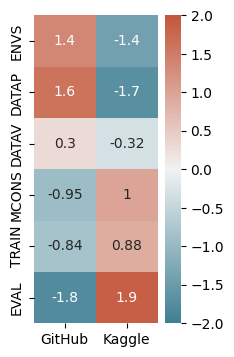

In [18]:
# test which variables contribute more to the difference

import seaborn as sns
import matplotlib.pyplot as plt

residuals_std_df = residuals_std_df[config.order_mlpp]
plt.figure(figsize=(2,4))
cm_dp = sns.diverging_palette(220, 20, center="light", as_cmap=True)
rc_new = [config.mlpp2abbr[x] for x in residuals_std_df.columns]
s = sns.heatmap(residuals_std_df[config.order_mlpp].T, annot=True, yticklabels=rc_new, cmap=cm_dp, 
                center=0,vmin=-2, vmax=2)
s.set(xlabel='', ylabel='')
# plt.savefig(config.path_default.joinpath('mlpp_residuals.pdf'), bbox_inches='tight')
plt.show()